In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import SEIR_full.model_class as mdl
from PolicyOptimization import EvaluatePolicy as pol
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy
import os
import time
from operator import add

In [2]:
with (open('../Data/parameters/indices.pickle', 'rb')) as openfile:
    ind = pickle.load(openfile)

# Setting parameters to present

In [15]:
make_spec_plots = True
make_summ_plots = False
base_thresh = 1000

parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
#     (1,'-'),
    (1,29),
]

stops_type = [
#     (True, 'all'),
#     (True, 'risk'),
#     (True, 'kid'),
    (False, 'all'),
    (False, 'risk'),
#     (False, 'kid'),
]

threshs = [
#     0.1,
#     0.2,
#     0.4,
#     0.6,
#     0.8,
    0.5,
]

start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

# Pre-procesing

In [7]:
# generate pop per region per inter:
pop_per_region_dict = {}
for stop in list(set([stop for (glob, stop) in stops_type])):
    if stop == 'all':
        pop_per_region = [np.sum(mdl.population_size[ind.region_dict[region]]) for region in ind.G.values()]
    elif stop == 'kid':
        pop_per_region = [mdl.population_size[list(set(ind.region_age_dict[(region, '0-4')]).union(
                             set(ind.region_age_dict[(region, '5-9')])).union(
                             set(ind.region_age_dict[(region, '10-19')])))].sum()
                             for  region in list(ind.G.values())
                         ]
    elif stop == 'risk':
        pop_per_region = list(map(add, 
            [mdl.population_size[list(set(ind.region_risk_dict[(region, 'High')]).union(
                set(ind.region_age_dict[(region, '70+')])))].sum()
                for  region in list(ind.G.values())
            ], 
            [mdl.population_size[list(set(ind.region_risk_dict[(region, 'Low')]).intersection(
                set(ind.region_age_dict[(region, '60-69')])))].sum()*0.5
                for region in list(ind.G.values())
            ],
        ))
    pop_per_region_dict[stop] = pop_per_region

# Loading data and generating all graphs

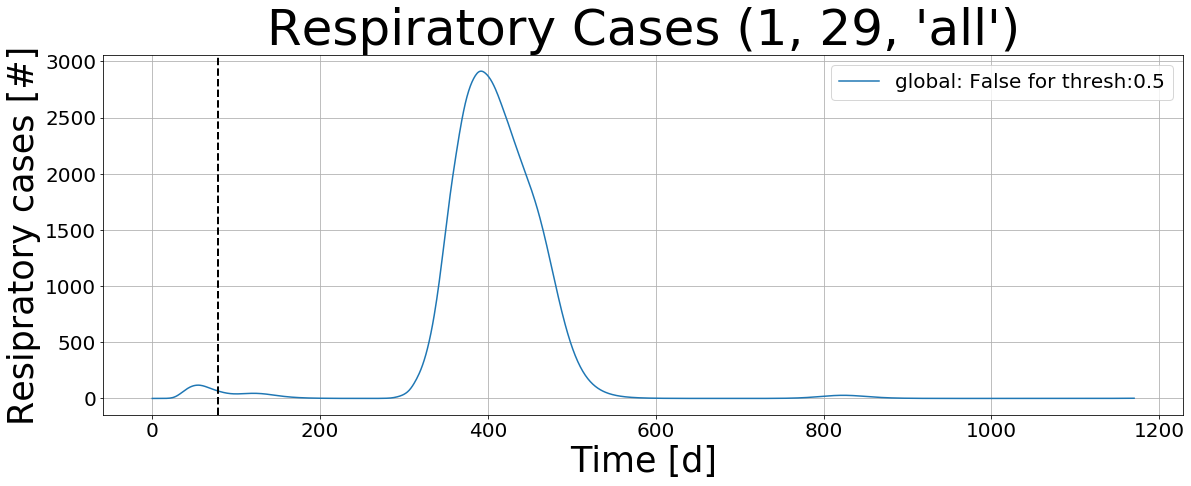

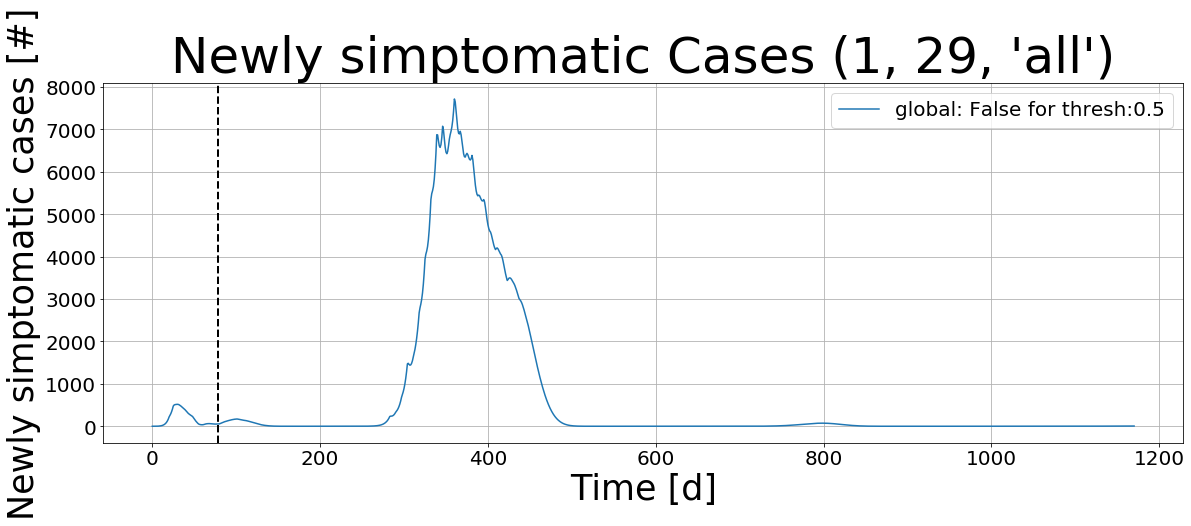

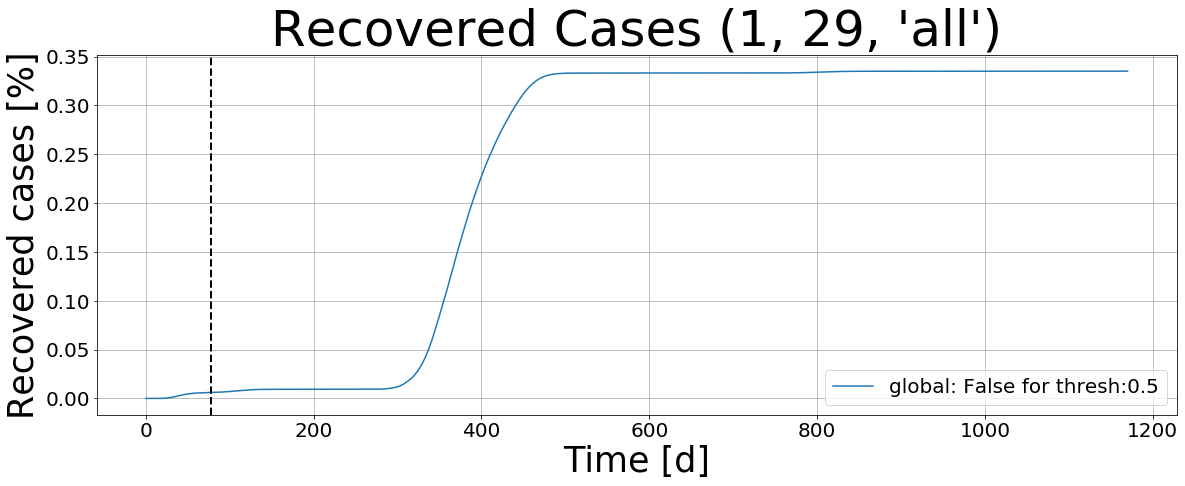

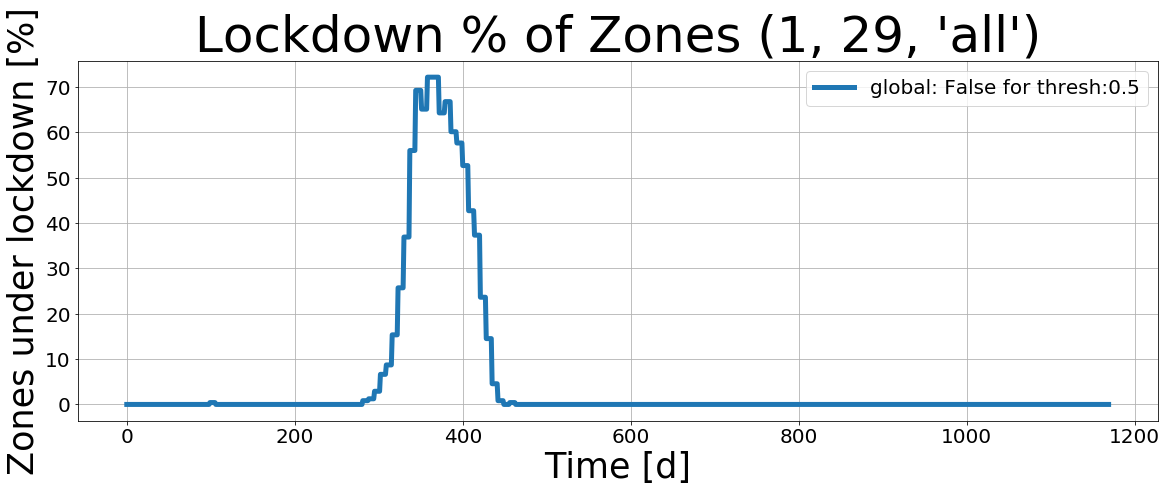

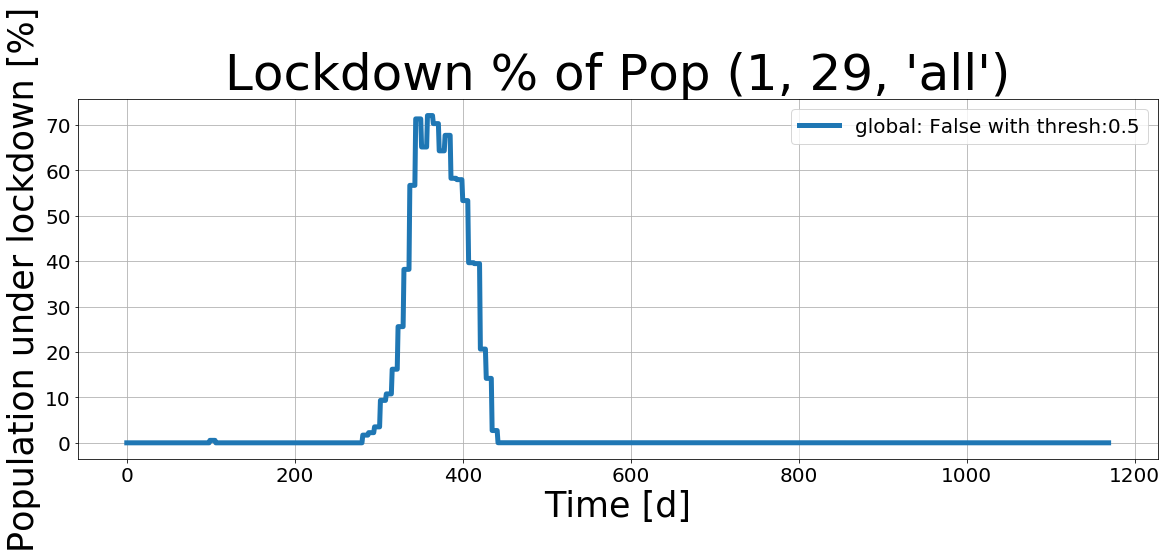

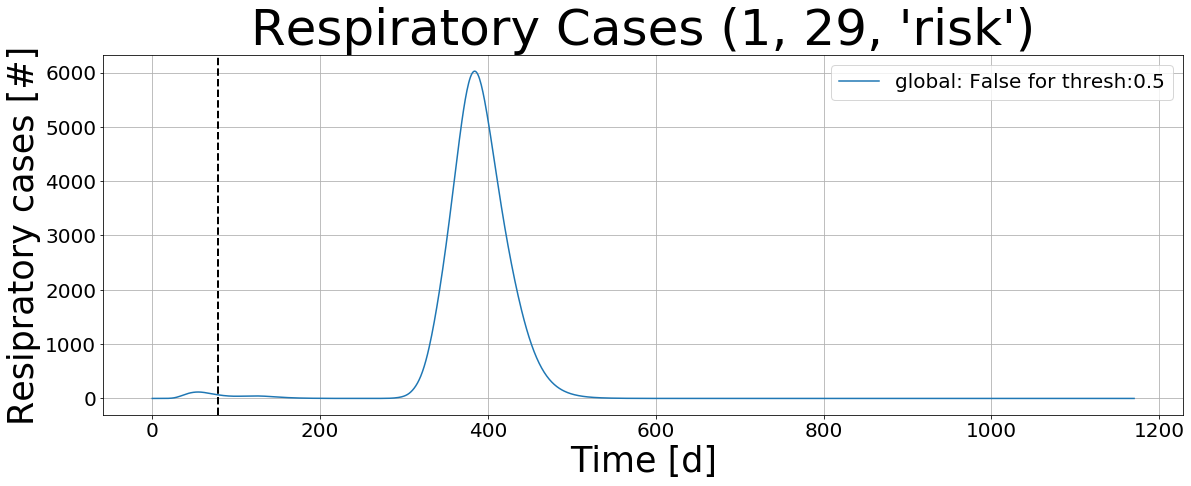

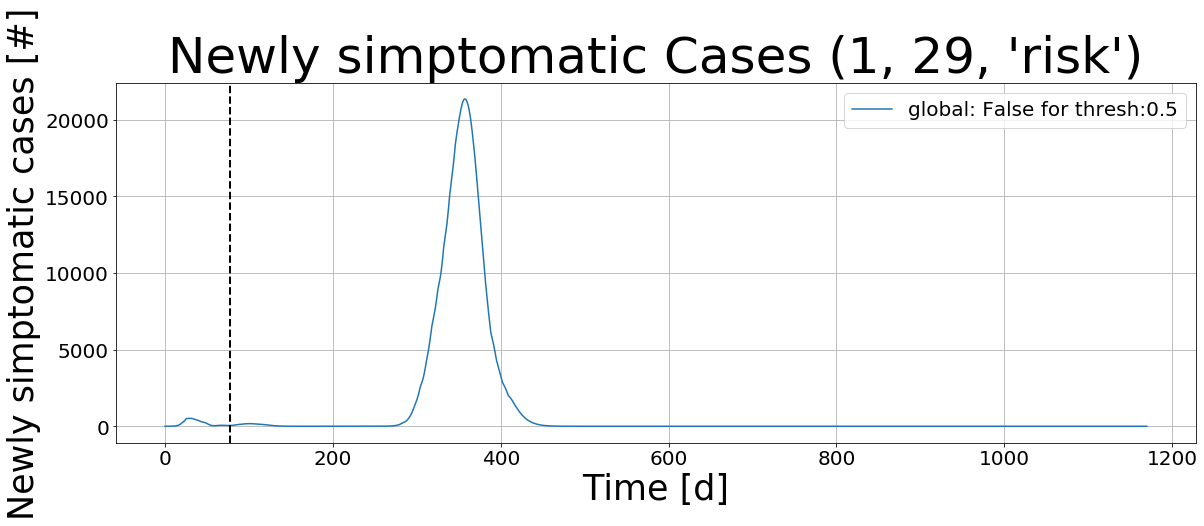

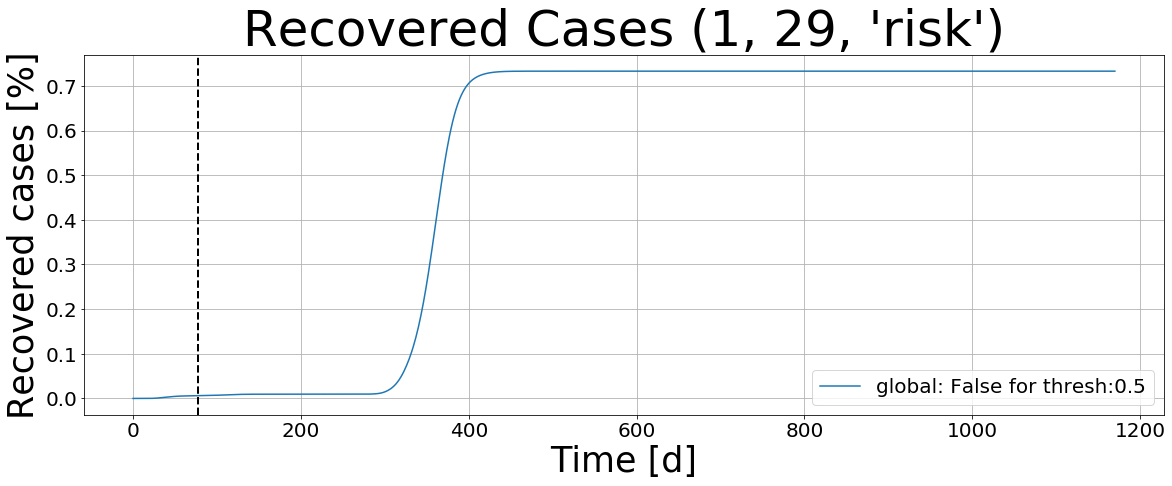

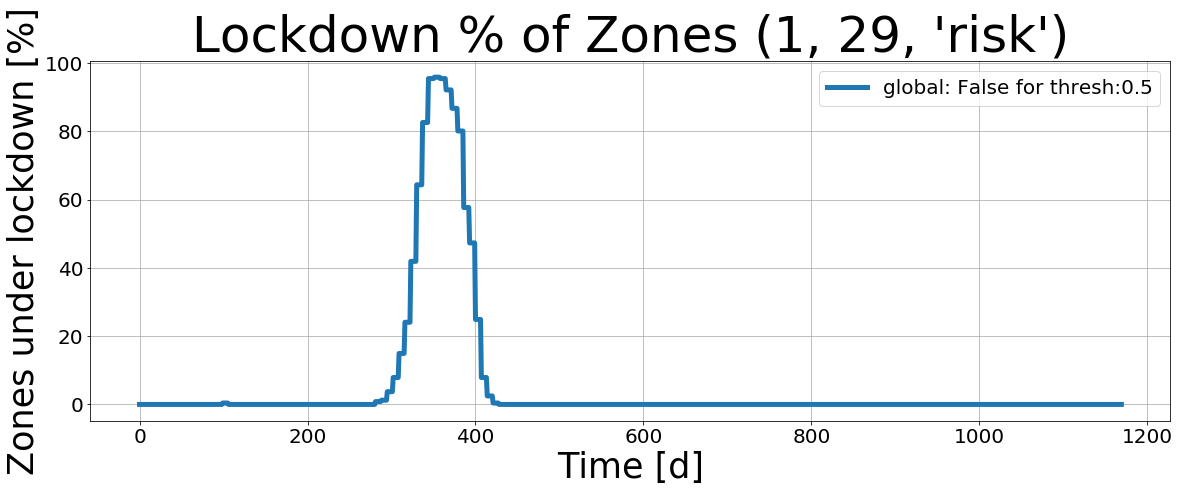

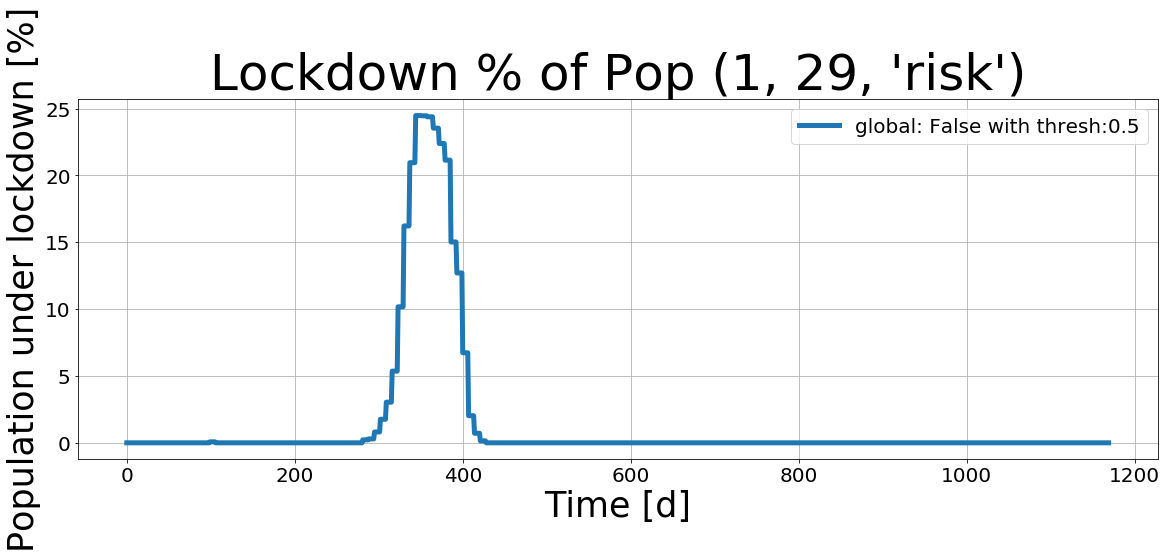

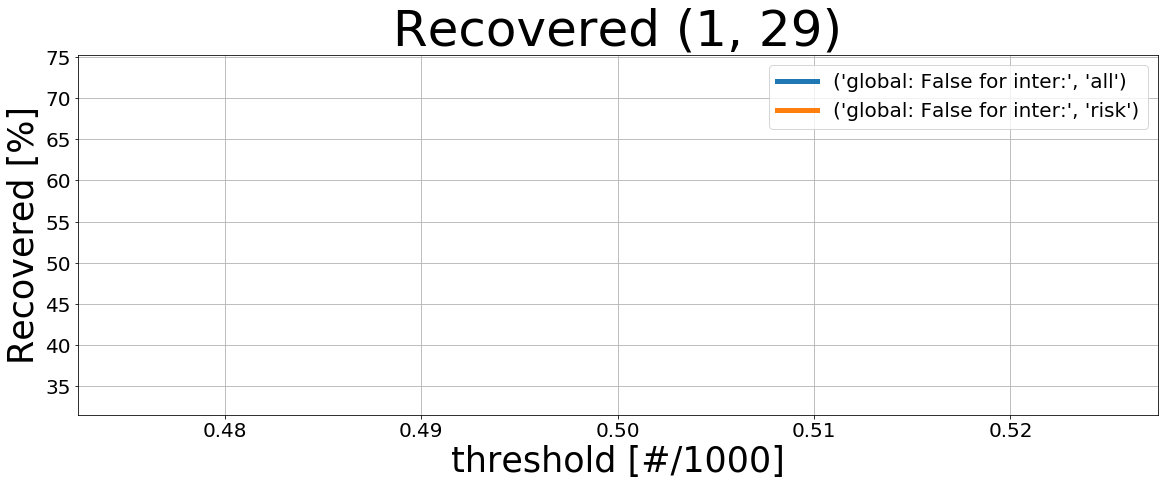

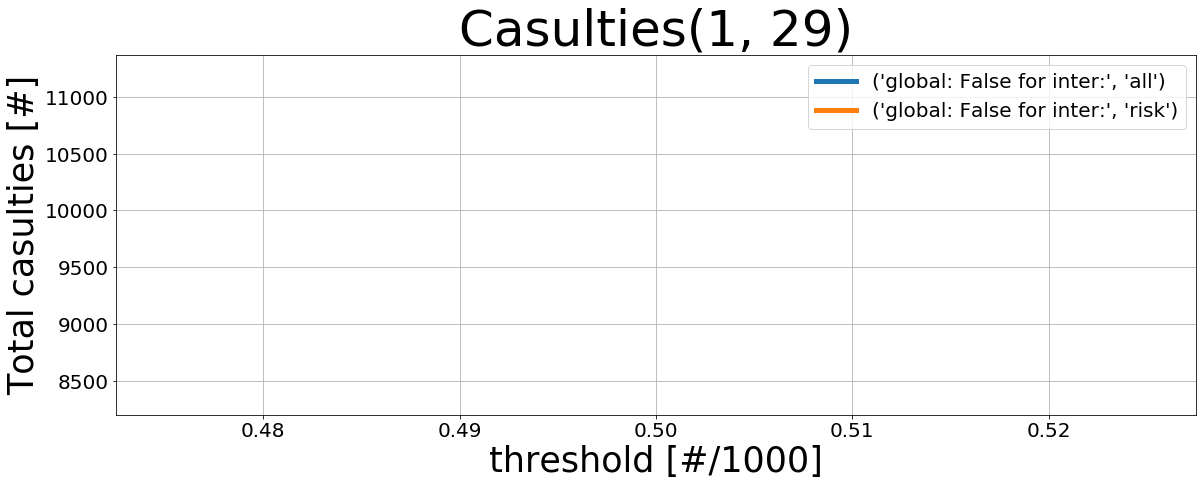

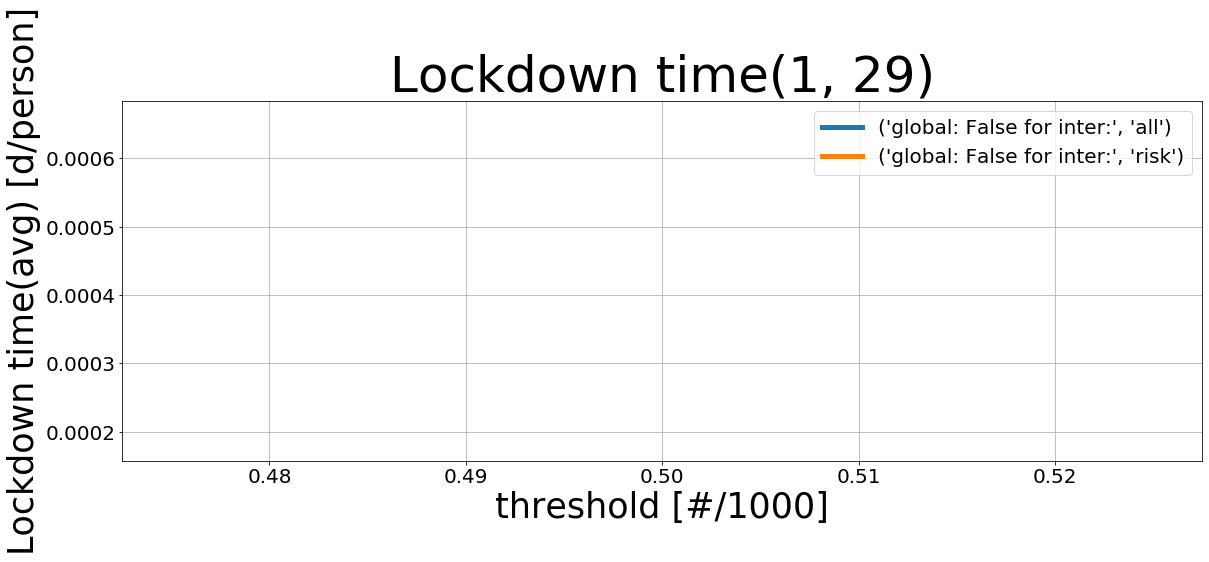

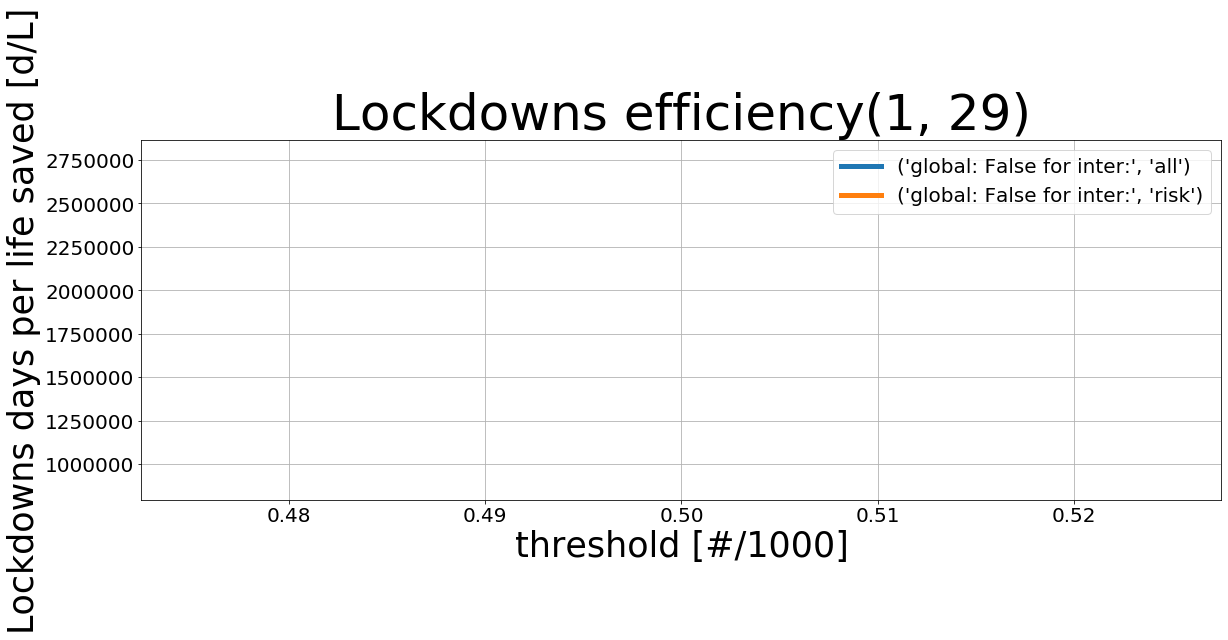

In [16]:
cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    res_mdl = {}
    pol_states = {}
    # load worst case for scenario and seasonality:
    with open('../Data/results/quarantine_mod_res' + 
                  '_'.join([str(x) for x in [scen_idx, phase, 'all', True, base_thresh]]) + 
                   '.pickle', 'rb') as openfile:
        res_mdl[base_thresh] = pickle.load(openfile) 

    # load the rest of the reslults per stop option and threshold
    for i, (glob, stop) in enumerate(stops_type):
        for thresh in threshs:
            try:
                with open('../Data/results/quarantine_mod_res' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle', 'rb') as openfile:
                    res_mdl[(glob, stop, thresh)] = pickle.load(openfile)
                with open('../Data/results/quarantine_regions' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle', 'rb') as openfile:
                    pol_states[(glob, stop, thresh)] = pickle.load(openfile)
            except: pass
            
        if make_spec_plots:
            ### plot different threshold along times: ###
            # number of resperatory cases global.
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_position([0, 0.5, 1, 0.5])
            for thresh in threshs:
                ax.plot(
                    ((res_mdl[(glob, stop, thresh)]['Vents']).sum(axis=1))*mdl.pop_israel, 
                    label=('global: '+ str(glob) + ' for thresh:' + str(thresh)))
            ax.set_ylabel('Resipratory cases [#]', fontsize=35)
            ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
            ax.set_xlabel('Time [d]', fontsize=35)
            ax.axvline(x=(start_inter-beginning).days, c='k', linewidth=2, linestyle='--')
            ax.legend(fontsize = 20)
            ax.grid('on')
            plt.setp(ax.get_xticklabels(), fontsize=20)    
            plt.setp(ax.get_yticklabels(), fontsize=20) 
            plt.show()

            # number of new cases cases global.
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_position([0, 0.5, 1, 0.5])
            for thresh in threshs:
                ax.plot(
                    ((res_mdl[(glob, stop, thresh)]['new_Is']).sum(axis=1))*mdl.pop_israel, 
                    label=('global: '+ str(glob) + ' for thresh:' + str(thresh)))
            ax.set_ylabel('Newly simptomatic cases [#]', fontsize=35)
            ax.set_title('Newly simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
            ax.set_xlabel('Time [d]', fontsize=35)
            ax.axvline(x=(start_inter-beginning).days, c='k', linewidth=2, linestyle='--')
            ax.legend(fontsize = 20)
            ax.grid('on')
            plt.setp(ax.get_xticklabels(), fontsize=20)    
            plt.setp(ax.get_yticklabels(), fontsize=20) 
            plt.show()

            # number of recovered cases global.
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_position([0, 0.5, 1, 0.5])
            for thresh in threshs:
                ax.plot(
                    ((res_mdl[(glob, stop, thresh)]['R']).sum(axis=1)), 
                    label=('global: '+ str(glob) + ' for thresh:' + str(thresh)))
            ax.set_ylabel('Recovered cases [%]', fontsize=35)
            ax.set_title('Recovered Cases ' + str((scen_idx, phase, stop)), fontsize=50)
            ax.set_xlabel('Time [d]', fontsize=35)
            ax.axvline(x=(start_inter-beginning).days, c='k', linewidth=2, linestyle='--')
            ax.legend(fontsize = 20)
            ax.grid('on')
            plt.setp(ax.get_xticklabels(), fontsize=20)    
            plt.setp(ax.get_yticklabels(), fontsize=20) 
            plt.show()

            # pct of regions in lockdowns.
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_position([0, 0.5, 1, 0.5])
            for thresh in threshs:
                pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states[(glob, stop, thresh)]]
                ax.plot(np.arange((start_inter-beginning).days + len(pol_pct)),
                        [0]* (start_inter-beginning).days+ pol_pct,linewidth=5, 
                        label=('global: '+ str(glob) + ' for thresh:' + str(thresh)))
            ax.set_ylabel('Zones under lockdown [%]', fontsize=35)
            ax.set_xlabel('Time [d]', fontsize=35)
            ax.set_title('Lockdown % of Zones ' + str((scen_idx, phase, stop)), fontsize=50)
            ax.grid('on')
            ax.legend(fontsize = 20)
            plt.setp(ax.get_xticklabels(), fontsize=20)    
            plt.setp(ax.get_yticklabels(), fontsize=20) 
            plt.show()

            # pct of pop in lockdown.
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_position([0, 0.5, 1, 0.5])
            for thresh in threshs:
                pol_pct = [100*sum(np.multiply(list(x.values()), pop_per_region_dict[stop])) 
                           for x in pol_states[(glob, stop, thresh)]]
                ax.plot(np.arange((start_inter-beginning).days + len(pol_pct)), 
                        [0] * (start_inter-beginning).days+pol_pct,linewidth=5, label=('global: '+ 
                               str(glob) +
                               ' with thresh:' + 
                               str(thresh)))
            ax.set_ylabel('Population under lockdown [%]', fontsize=35)
            ax.set_xlabel('Time [d]', fontsize=35)
            ax.set_title('Lockdown % of Pop ' + str((scen_idx, phase, stop)), fontsize=50)
            ax.grid('on')
            ax.legend(fontsize = 20)
            plt.setp(ax.get_xticklabels(), fontsize=20)    
            plt.setp(ax.get_yticklabels(), fontsize=20) 
            plt.show()
    
    if make_summ_plots:
        ### plot different summeries: ###
        # make recoveries:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            recovered = []
            for thresh in threshs:
                recovered.append(mdl.make_recoveries(res_mdl[(glob, stop, thresh)], -1))
            ax.plot(threshs, recovered,linewidth=5, label=('global: '+ str(glob) + ' for inter:', stop))
        ax.set_ylabel('Recovered [%]', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Recovered ' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # make casulties:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            casul = []
            for thresh in threshs:
                casul.append(
                      mdl.make_casulties(res_mdl[(glob, stop, thresh)], -1, mdl.pop_israel, mdl.mu))
            ax.plot(threshs, casul,linewidth=5, label=('global: '+ str(glob) + ' for inter:', stop))
        ax.set_ylabel('Total casulties [#]', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Casulties' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # make lockdown:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            lock = []
            for thresh in threshs:
                lock.append(
                      np.sum([100*sum(np.multiply(list(x.values()), pop_per_region_dict[stop])) 
                       for x in pol_states[(glob, stop, thresh)]])/mdl.pop_israel)
            ax.plot(threshs, lock,linewidth=5, label=('global: '+ str(glob) + ' for inter:', stop))
        ax.set_ylabel('Lockdown time(avg) [d/person]', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Lockdown time' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # make lockdown days per lives:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            lock_per_lives = []
            for thresh in threshs:
                quar = np.sum([100*sum(np.multiply(list(x.values()), pop_per_region_dict[stop])) 
                       for x in pol_states[(glob, stop, thresh)]])*mdl.pop_israel
                lock_per_lives.append(quar/(
                    mdl.make_casulties(res_mdl[base_thresh], -1, mdl.pop_israel, mdl.mu) - 
                    mdl.make_casulties(res_mdl[(glob, stop, thresh)], -1, mdl.pop_israel, mdl.mu)))

            ax.plot(threshs, lock_per_lives, linewidth=5, label=('global: '+ str(glob) + ' for inter:', stop))
        ax.set_ylabel('Lockdowns days per life saved [d/L]', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Lockdowns efficiency' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

# reconstructing sergey old opt

In [6]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
    (1,'-'),
    (1,29),
]

stops_type = [
#     (True, 'all'),
    (True, 'risk'),
#     (True, 'nothing'),
#     (False, 'all'),
    (False, 'risk'),
#     (False, 'kid'),
]

In [7]:
policy_params_list = []
policy_params = {
    'policy_period': 7,
    'stop_inter': mdl.inter2name(ind, 10),
    'free_inter': mdl.inter2name(ind, 100, no_risk=False),
    'deg_param': None,
    'global_thresh': False,
    'max_duration': 100,
    'threshold': 1,
}
# policy_params = {
#     'policy_period': 7,
#     'stop_inter': mdl.inter2name(ind, 10),
#     'free_inter': mdl.inter2name(ind, 100, no_risk=False),
#     'deg_param': None,
#     'global_lock': True,
#     'global_thresh': True,
#     'max_duration': 2,
#     'threshold': 5e2,
# }

# [Is, new_Is, H, Vent]
policy_params['weight_matrix'] = np.zeros([4,9])
policy_params['weight_matrix'][1][:] = 1
policy_params_list.append(policy_params.copy())

policy_params['threshold']=2
policy_params_list.append(policy_params.copy())

policy_params['threshold']=3
policy_params_list.append(policy_params.copy())

policy_params['threshold']=4
policy_params_list.append(policy_params.copy())

policy_params['threshold']=5
policy_params_list.append(policy_params.copy())

policy_params['threshold']=6
policy_params_list.append(policy_params.copy())

policy_params['threshold']=7
policy_params_list.append(policy_params.copy())

policy_params['threshold'] = 1000
policy_params_list.append(policy_params.copy())

In [8]:
len(policy_params_list)

8

In [ ]:
start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}
res_mdl = {}
pol_states = {}
for scen_idx, phase in cal_parameters.keys():
    if phase == '-':
        seasonality = False
        phi=0
    else:
        seasonality = True
        phi=phase
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[(scen_idx, phase)]['beta_j'],
        theta=cal_parameters[(scen_idx, phase)]['theta'],
        beta_behave=cal_parameters[(scen_idx, phase)]['beta_behave'],
        mu=cal_parameters[(scen_idx, phase)]['mu'],
        nu=cal_parameters[(scen_idx, phase)]['nu'],
        eta=cal_parameters[(scen_idx, phase)]['eta'],
        xi=cal_parameters[(scen_idx, phase)]['xi'],
        scen=mdl.num2scen(scen_idx),
        seasonality=seasonality,
        phi=phi,
    )

    res = model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    for glob, stop in stops_type:
        res_mdl[(scen_idx, phase, stop)] = []
        pol_states[(scen_idx, phase, stop)] = []
        for policy_params in policy_params_list:
            
            policy_params['global_thresh'] = glob
            policy_params['global_lock'] = glob
            if stop == 'all':
                policy_params['stop_inter'] = mdl.inter2name(ind, 10)
            elif stop == 'kid':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=False, no_kid=True)
            elif stop == 'risk':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=True)
                policy_params['free_inter'] = mdl.inter2name(ind, 100, no_risk=False)
            elif stop == 'nothing':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=False)
                policy_params['free_inter'] = mdl.inter2name(ind, 100, no_risk=False)
            
            thresh = policy_params['threshold']
            print('Doing: ', ' '.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]))
            res_mdl_glob_i, pol_states_i = pol.run_global_policy(
                ind, 
                model, 
                policy_params, 
                3*365+1, 
                mdl.pop_israel,
                start=(start_inter-beginning).days,
            )
            res_mdl[(scen_idx, phase, stop, glob, thresh)] = res_mdl_glob_i.copy()
            pol_states[(scen_idx, phase, stop, glob, thresh)] = pol_states_i.copy()

Doing:  1 - risk True 1
Doing:  1 - risk True 2
Doing:  1 - risk True 3
Doing:  1 - risk True 4
Doing:  1 - risk True 5
Doing:  1 - risk True 6
Doing:  1 - risk True 7
Doing:  1 - risk True 1000
Doing:  1 - risk False 1
Doing:  1 - risk False 2
Doing:  1 - risk False 3
Doing:  1 - risk False 4
Doing:  1 - risk False 5
Doing:  1 - risk False 6
Doing:  1 - risk False 7
Doing:  1 - risk False 1000
Doing:  1 29 risk True 1
Doing:  1 29 risk True 2
Doing:  1 29 risk True 3
Doing:  1 29 risk True 4
Doing:  1 29 risk True 5
Doing:  1 29 risk True 6
Doing:  1 29 risk True 7
Doing:  1 29 risk True 1000
Doing:  1 29 risk False 1
Doing:  1 29 risk False 2
Doing:  1 29 risk False 3
Doing:  1 29 risk False 4


(1, '-', 'all')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  62.81070019918911
total casulties:  14690.211362516895
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  70.0727132775543
total casulties:  17107.221782889173
{'policy_period': 7, 'stop_inter': '

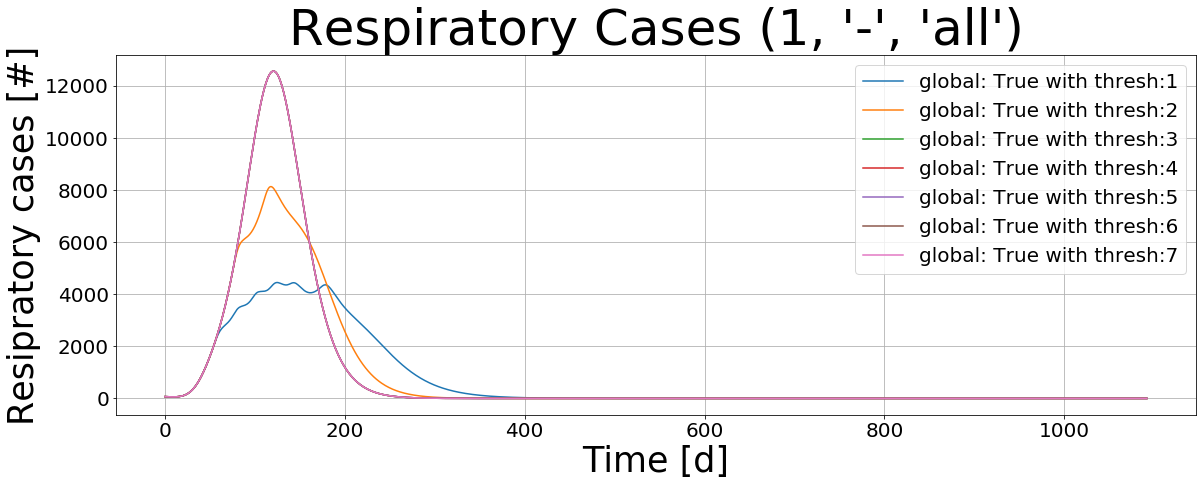

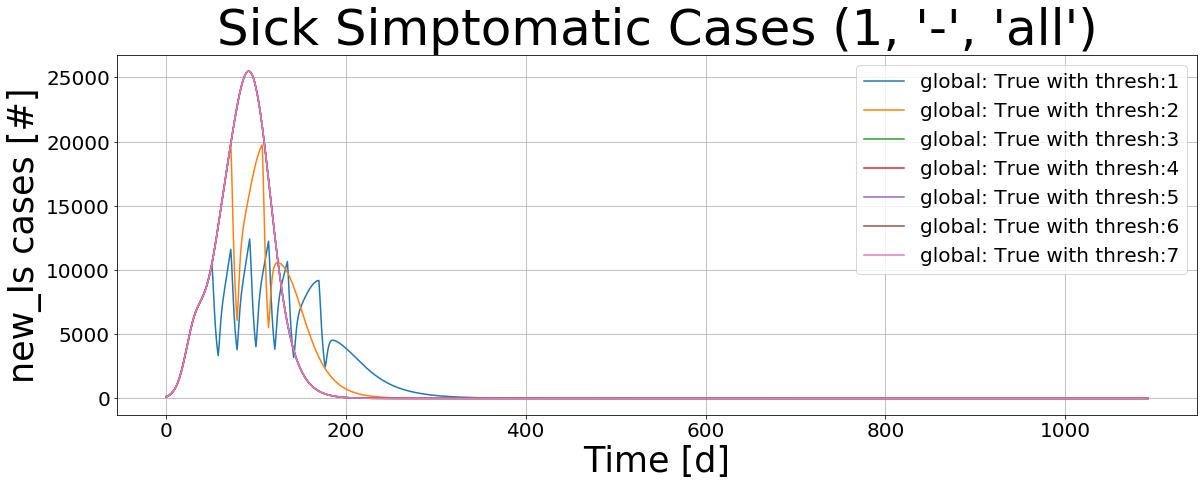

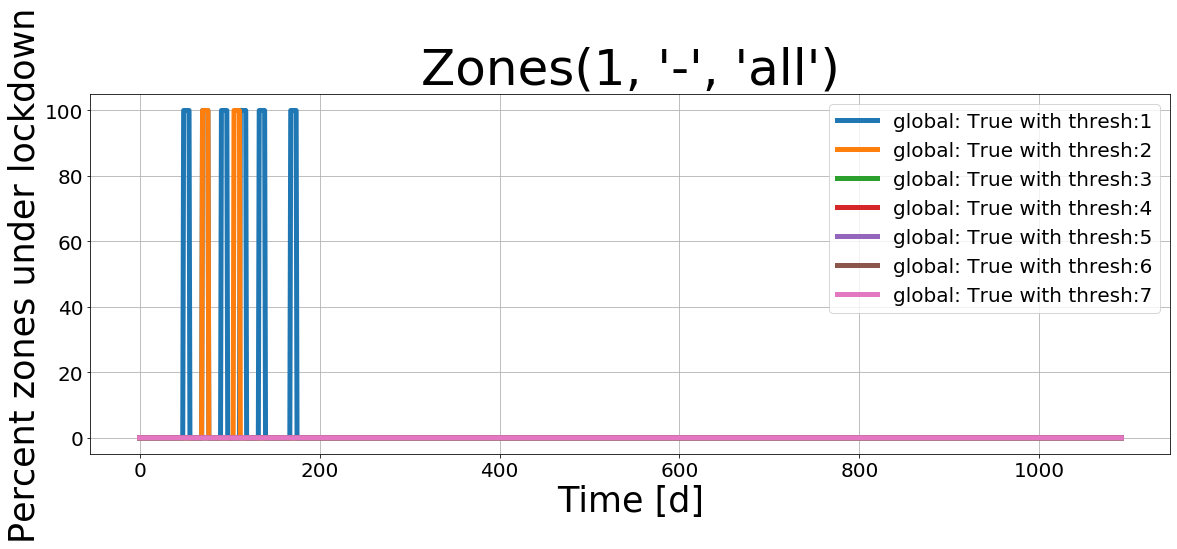

(1, '-', 'all')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  62.57197323520567
total casulties:  14744.83752344136
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  67.43053204083964
total casulties:  16343.570000892387
{'policy_period': 7, 'stop_inter': '

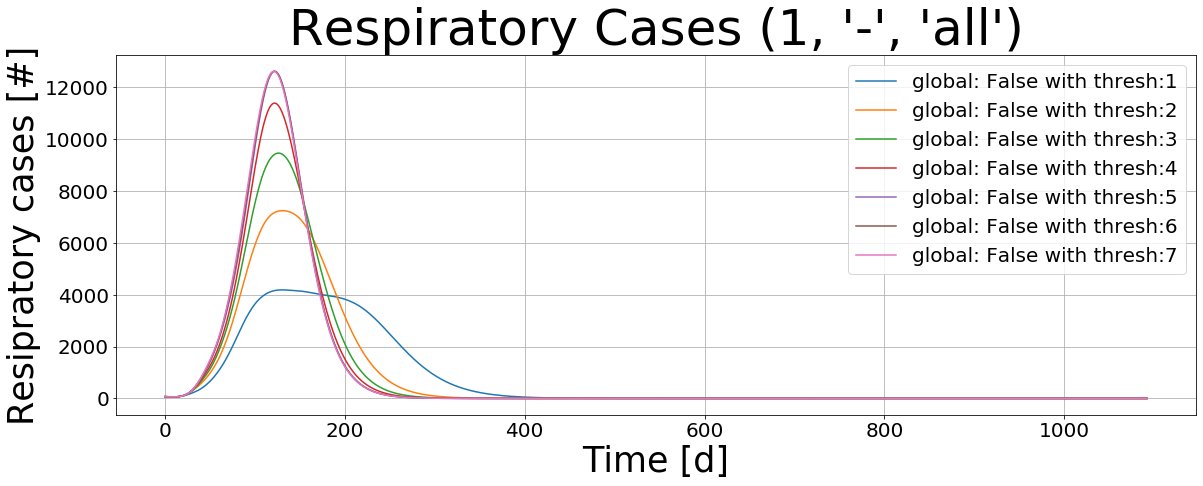

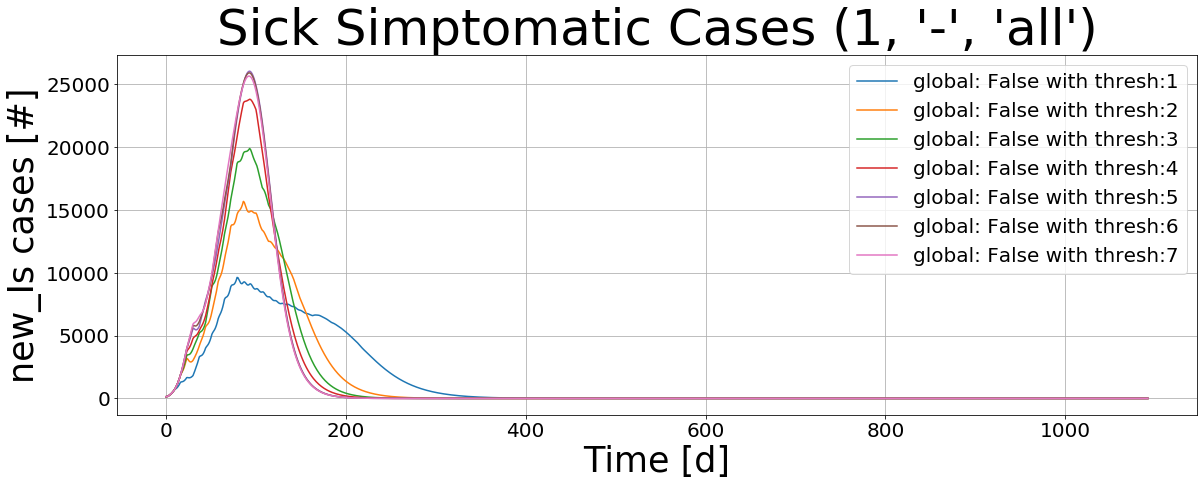

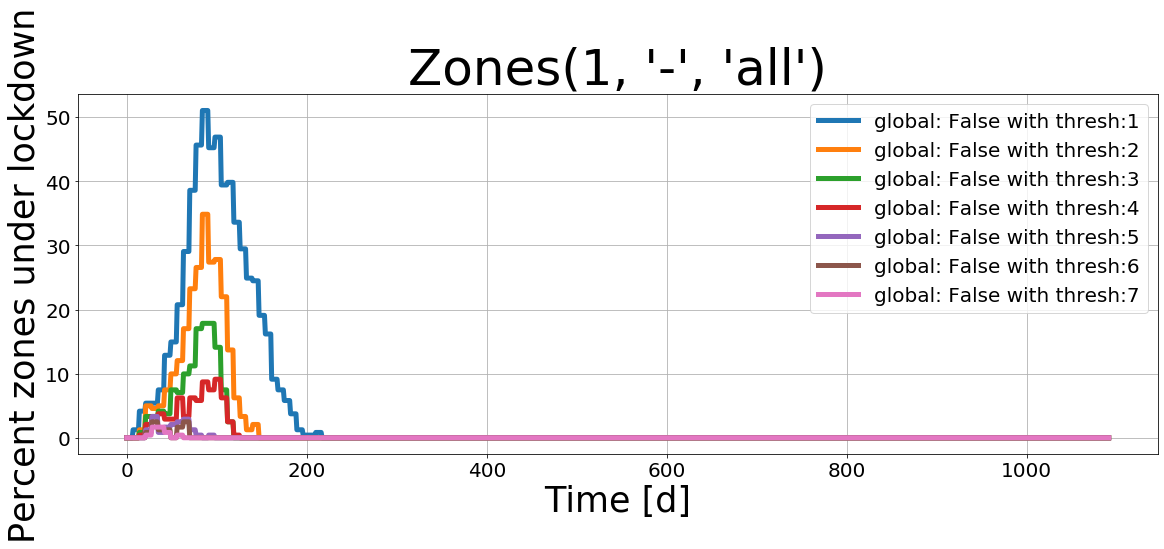

(1, '-', 'kid')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  67.83403828994757
total casulties:  18474.652916975083
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  70.06004419326362
total casulties:  18807.873962741065
{'policy_period': 7, 'stop_inter': 

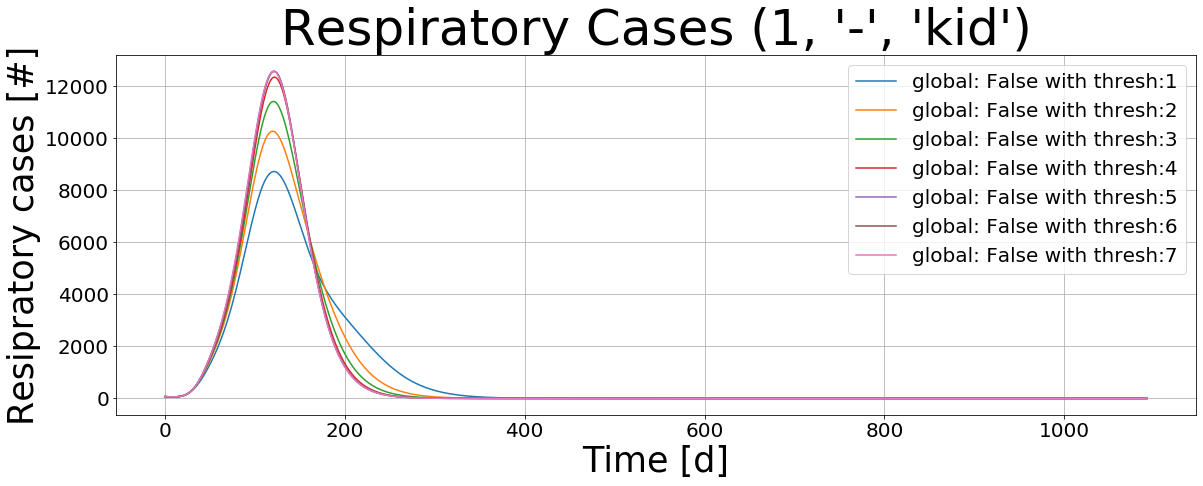

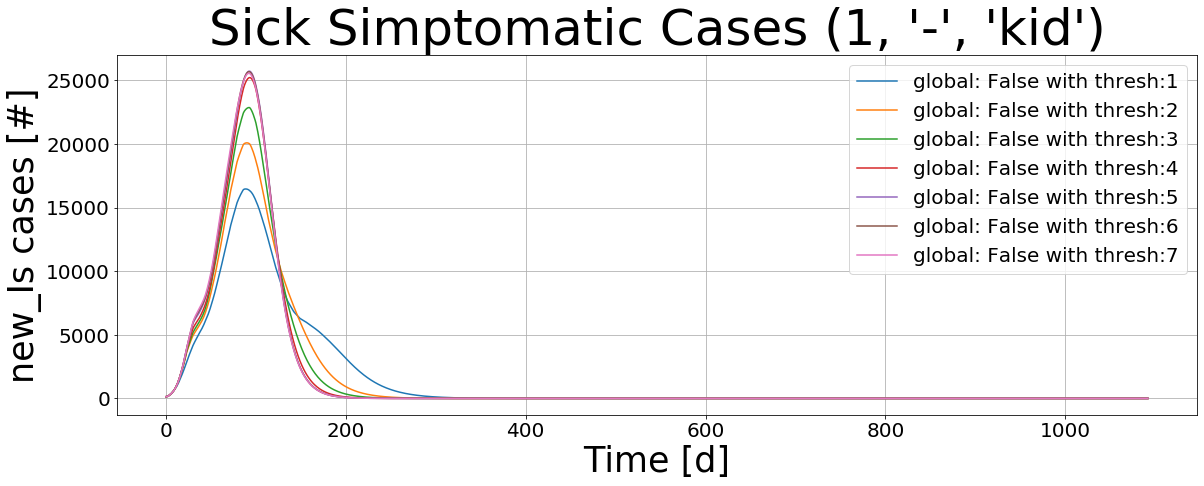

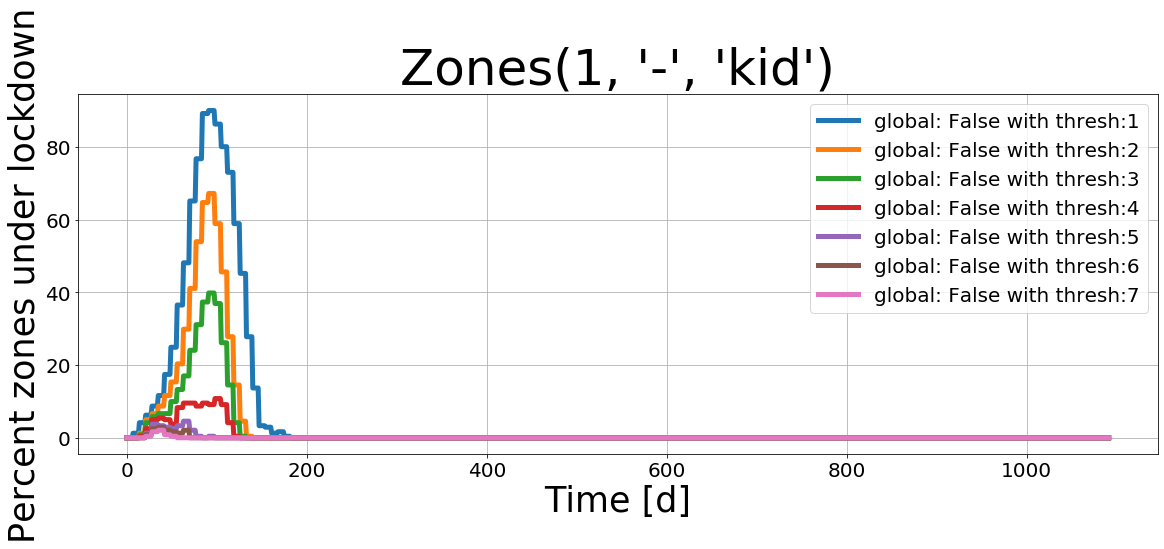

(1, 29, 'all')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  58.749025450353386
total casulties:  12698.531661424218
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  74.09879889058564
total casulties:  17700.614371154323
{'policy_period': 7, 'stop_inter': 

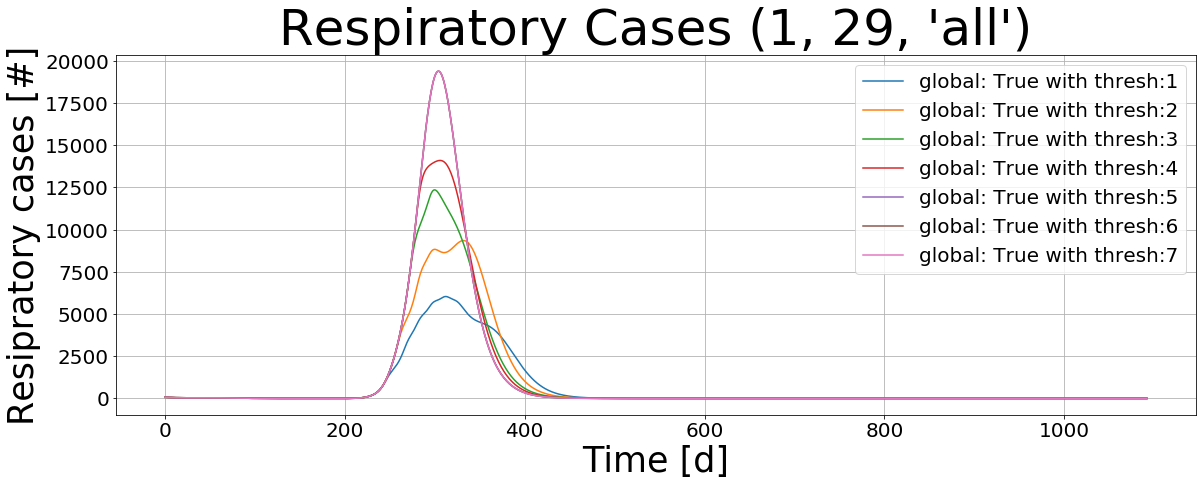

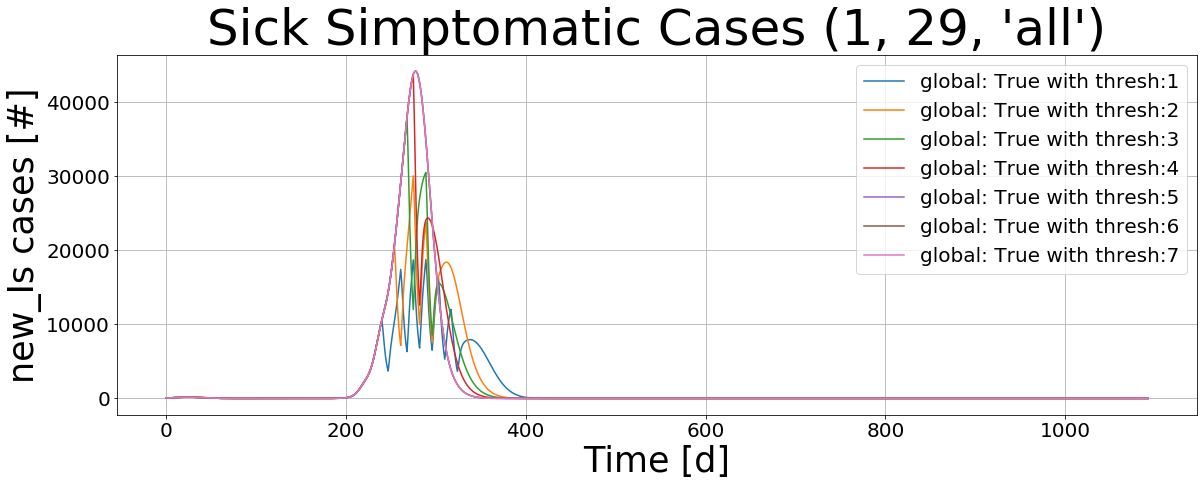

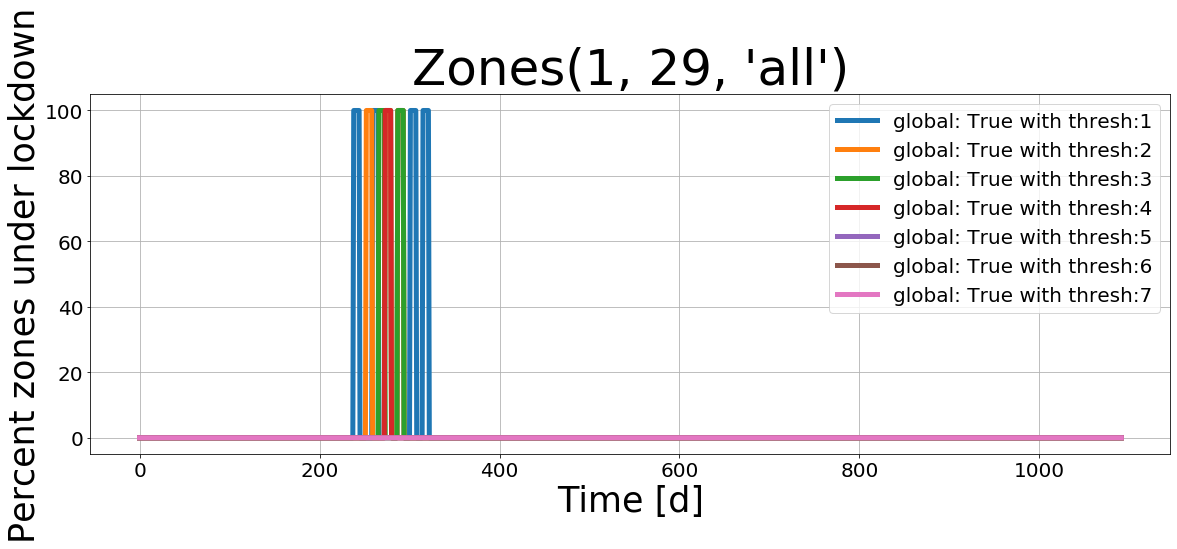

(1, 29, 'all')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  49.24643135955881
total casulties:  10206.930789711434
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  65.28336490890393
total casulties:  14800.320699423684
{'policy_period': 7, 'stop_inter': '

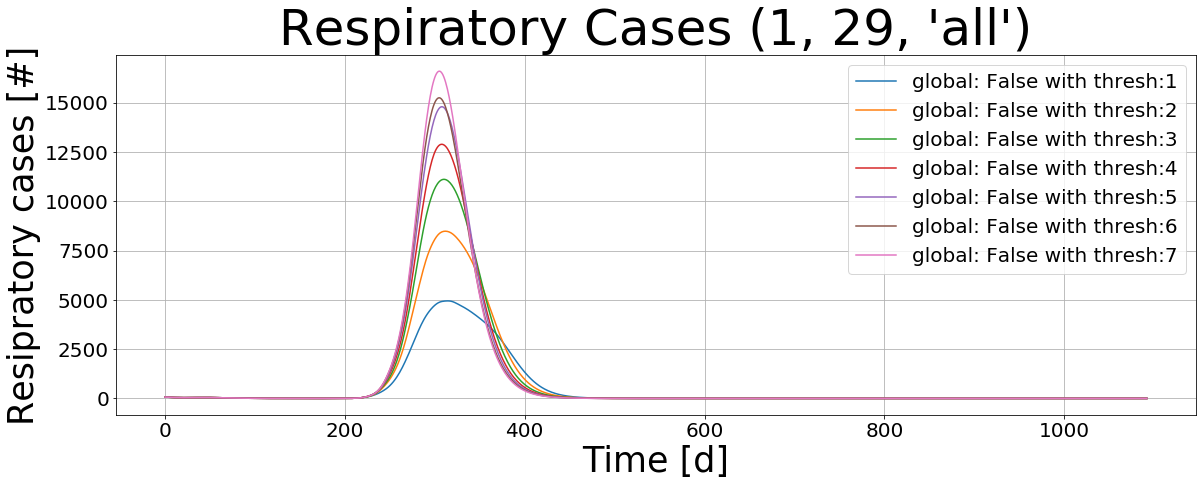

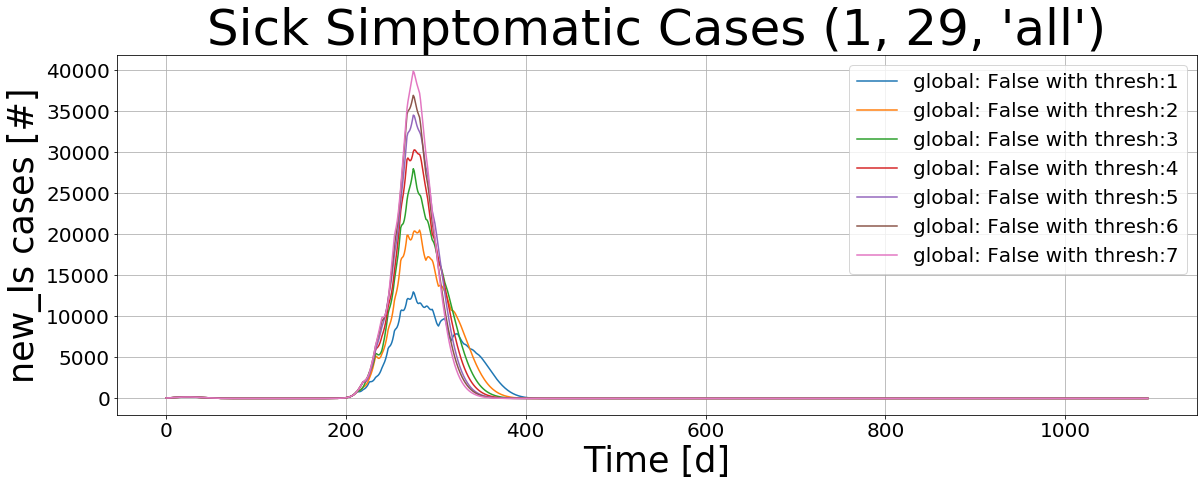

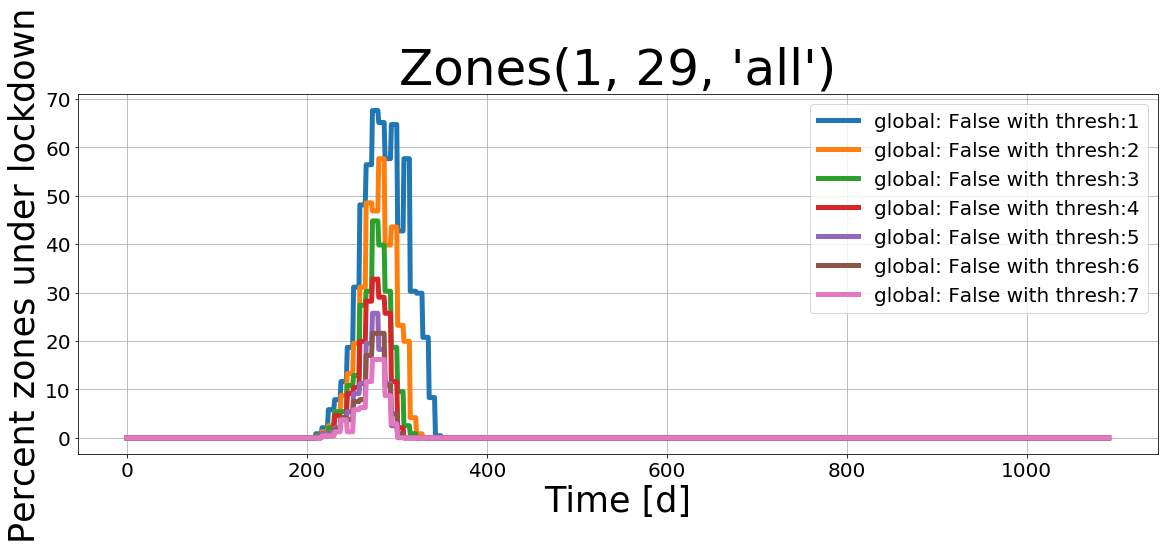

(1, 29, 'kid')
After  3.0  years:
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
1
Recovered cases max:  67.20204268469067
total casulties:  20302.368749070312
{'policy_period': 7, 'stop_inter': '250@100_no_kid', 'free_inter': '250@100_kid019', 'deg_param': None, 'global_thresh': False, 'max_duration': 100, 'threshold': 1, 'weight_matrix': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'global_lock': False}
2
Recovered cases max:  73.75020857206125
total casulties:  21331.365247729238
{'policy_period': 7, 'stop_inter': '

KeyError: (1, 29, 'kid', False, 4)

In [38]:
cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    for glob, stop in stops_type:
        print((scen_idx, phase, stop))
        for y in 365*np.array([3]):
            print('After ', y/365.0, ' years:')
            for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#             for thresh in [1]:
                if thresh == 1000:
                    continue
#                 print(policy_params_list[i])
                print((scen_idx, phase, stop, glob, thresh))
                print('Recovered cases max: ',
                      mdl.make_recoveries(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y)))
                print('total casulties: ', 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu))
                print('total casulties saved per quar: ', 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, 1000)], int(y), mdl.pop_israel, model.mu) - 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu))
            print()
        
        # number of resperatory cases global.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            ax.plot(
                ((res_mdl[(scen_idx, phase, stop, glob, thresh)]['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
                label=('global: '+ 
                       str(glob) +
                       ' with thresh:' + 
                       str(thresh)))
        ax.set_ylabel('Resipratory cases [#]', fontsize=35)
        ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
        ax.set_xlabel('Time [d]', fontsize=35)
        # ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
        ax.legend(fontsize = 20)
        ax.grid('on')
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # number of new cases global.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            ax.plot(
                ((res_mdl[(scen_idx, phase, stop, glob, thresh)]['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
                label=('global: '+ 
                       str(glob) +
                       ' with thresh:' + 
                       str(thresh)))
        ax.set_ylabel('new_Is cases [#]', fontsize=35)
        ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
        ax.set_xlabel('Time [d]', fontsize=35)
        # ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
        ax.legend(fontsize = 20)
        ax.grid('on')
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # pct of regions in quaer.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states[(scen_idx, phase, stop, glob, thresh)]]
            ax.plot(pol_pct,linewidth=5, label=('global: '+ 
                           str(glob) +
                           ' with thresh:' + 
                           str(thresh)))
        ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('Time [d]', fontsize=35)
        ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
        
        # pct of pop in quaer.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states[(scen_idx, phase, stop, glob, thresh)]]
            ax.plot(pol_pct,linewidth=5, label=('global: '+ 
                           str(glob) +
                           ' with thresh:' + 
                           str(thresh)))
        ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('Time [d]', fontsize=35)
        ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

In [1]:
for scen_idx, phase in cal_parameters.keys():
    for y in 365*np.array([1, 2, 3]):
        print('After ', y/365.0, ' year:')
        print((scen_idx, phase))
        # make recoveres:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for stop in ['all', 'kid']:
            recovered = []
            thresh = []
            for i in range(7):
                thresh.append(policy_params_list[i]['threshold'])
                recovered.append(mdl.make_recoveries(res_mdl[(scen_idx, phase, stop)][i], int(y)))
            ax.plot(thresh, recovered,linewidth=5, label=('global: '+ 
                       str(policy_params_list[i]['global_thresh']) +
                       ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Recovered pct' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
                
        # make saved:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for stop in ['all', 'kid']:
            saved = []
            thresh = []
            for i in range(7):
                thresh.append(policy_params_list[i]['threshold'])
                saved.append(
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop)][i], int(y), mdl.pop_israel, model.mu))
            ax.plot(thresh, saved,linewidth=5, label=('global: '+ 
                       str(policy_params_list[i]['global_thresh']) +
                       ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Total casulties' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
            
        # make save per quar.:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for stop in ['all', 'kid']:
            saved_per_q = []
            thresh = []
            for i in range(7):
                thresh.append(policy_params_list[i]['threshold'])
                if stop == 'all':
                    quar = np.sum([
                        np.sum(np.multiply(
                             [mdl.population_size[ind.region_dict[region]].sum()
                                for region in list(ind.G.values())
                            ],
                            list(pol_states[(1, '-', stop)][0][t].values()),
                        ))
                        for t in range(len(pol_states[(1, '-', stop)][0]))
                    ][:int(y)])*mdl.pop_israel
                elif stop == 'kid':
                    quar = np.sum([
                        np.sum(np.multiply(
                            [mdl.population_size[list(ind.region_age_dict[(region, '0-4')]) + \
                                                  list(ind.region_age_dict[(region, '5-9')]) + \
                                                  list(ind.region_age_dict[(region, '10-19')])].sum()
                                for region in list(ind.G.values())
                            ],
                            list(pol_states[(1, '-', stop)][0][t].values()),
                        ))
                        for t in range(len(pol_states[(1, '-', stop)][0]))
                    ][:int(y)])*mdl.pop_israel
                elif stop == 'risk':
                    quar = np.sum([
                        np.sum(np.multiply(
                            [mdl.population_size[list(set(ind.region_risk_dict[(region, 'High')]) + \
                                                  set(ind.region_age_dict[(region, '70+')]))].sum() + \
                             mdl.population_size[list(ind.region_age_dict[(region, '60-69')]).sum*0.5
                                for region in list(ind.G.values())
                            ],
                            list(pol_states[(1, '-', stop)][0][t].values()),
                        ))
                        for t in range(len(pol_states[(1, '-', stop)][0]))
                    ][:int(y)])*mdl.pop_israel
                saved_per_q.append((mdl.make_casulties(res_mdl[(scen_idx, phase, stop)][-1], int(y), mdl.pop_israel, model.mu) - 
                       mdl.make_casulties(res_mdl[(scen_idx, phase, stop)][i], int(y), mdl.pop_israel, model.mu))
                                   /quar)
                
            ax.plot(thresh, saved_per_q,linewidth=5, label=('global: '+ 
                       str(policy_params_list[i]['global_thresh']) +
                       ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Saved lives per quar.' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
            
        
    

SyntaxError: invalid syntax (<ipython-input-1-03b51c9a4f0a>, line 84)

In [15]:
len(res_mdl[list(res_mdl.keys())[0]])

16

In [28]:
# new_res_mdl = {}
# new_pol_states = {}
# for scen_idx, phase in cal_parameters.keys():
#     for stop in ['all', 'kid']:
#         for i in range(len(policy_params_list)):
#             try:
#                 glob = policy_params_list[i]['global_thresh']
#                 thresh = policy_params_list[i]['threshold']
#                 new_res_mdl[(scen_idx, phase, stop, glob, thresh)] = res_mdl[(scen_idx, phase, stop)][i]
#                 new_pol_states[(scen_idx, phase, stop, glob, thresh)] = pol_states[(scen_idx, phase, stop)][i]
#                 print(scen_idx, phase, stop, glob, thresh)
#             except:
#                 pass

1 - all False 1
1 - all False 2
1 - all False 3
1 - all False 4
1 - all False 5
1 - all False 6
1 - all False 7
1 - all True 1
1 - all True 1
1 - all True 2
1 - all True 3
1 - all True 4
1 - all True 5
1 - all True 6
1 - all True 7
1 - all True 1000
1 - kid False 1
1 - kid False 2
1 - kid False 3
1 - kid False 4
1 - kid False 5
1 - kid False 6
1 - kid False 7
1 - kid True 1
1 - kid True 1
1 - kid True 2
1 - kid True 3
1 - kid True 4
1 - kid True 5
1 - kid True 6
1 - kid True 7
1 - kid True 1000
1 29 all False 1
1 29 all False 2
1 29 all False 3
1 29 all False 4
1 29 all False 5
1 29 all False 6
1 29 all False 7
1 29 all True 1
1 29 all True 1
1 29 all True 2


In [39]:
# new_res_mdl
# new_pol_states
# try:
#     os.mkdir('../Data/results')
# except:
#     pass
# for scen_idx, phase in cal_parameters.keys():
#     for stop in ['all', 'kid']:
#         for i in range(len(policy_params_list)):
#             try:
#                 glob = policy_params_list[i]['global_thresh']
#                 thresh = policy_params_list[i]['threshold']
#                 print('../Data/results/quarantine_mod_res' + 
#                           '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
#                            '.pickle')
#                 with open('../Data/results/quarantine_mod_res' + 
#                           '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
#                            '.pickle', 'wb') as handle:
#                     pickle.dump(new_res_mdl[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
#             except:
#                 pass
# with open('../Data/results/quarantine_regions.pickle', 'wb') as handle:
#     pickle.dump(new_pol_states, handle, protocol=pickle.HIGHEST_PROTOCOL)

../Data/results/quarantine_mod_res1_-_all_False_1.pickle
../Data/results/quarantine_mod_res1_-_all_False_2.pickle
../Data/results/quarantine_mod_res1_-_all_False_3.pickle
../Data/results/quarantine_mod_res1_-_all_False_4.pickle
../Data/results/quarantine_mod_res1_-_all_False_5.pickle
../Data/results/quarantine_mod_res1_-_all_False_6.pickle
../Data/results/quarantine_mod_res1_-_all_False_7.pickle
../Data/results/quarantine_mod_res1_-_all_True_1.pickle
../Data/results/quarantine_mod_res1_-_all_True_1.pickle
../Data/results/quarantine_mod_res1_-_all_True_2.pickle
../Data/results/quarantine_mod_res1_-_all_True_3.pickle
../Data/results/quarantine_mod_res1_-_all_True_4.pickle
../Data/results/quarantine_mod_res1_-_all_True_5.pickle
../Data/results/quarantine_mod_res1_-_all_True_6.pickle
../Data/results/quarantine_mod_res1_-_all_True_7.pickle
../Data/results/quarantine_mod_res1_-_all_True_1000.pickle
../Data/results/quarantine_mod_res1_-_kid_False_1.pickle
../Data/results/quarantine_mod_res1_-

In [46]:
# idxs_list = []
for scen_idx, phase in cal_parameters.keys():
    for glob, stop in stops_type:
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
            if (scen_idx, phase, stop, glob, thresh) not in idxs_list:
                
                try:
                    print(len(res_mdl[(scen_idx, phase, stop, glob, thresh)]))

                    
                    with open('../Data/results/quarantine_mod_res' + 
                              '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                               '.pickle', 'wb') as handle:
                        pickle.dump(res_mdl[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
                    with open('../Data/results/quarantine_regions' + 
                              '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                               '.pickle', 'wb') as handle:
                        pickle.dump(pol_states[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print('../Data/results/quarantine_mod_res' + 
                              '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                               '.pickle')
                except:
                    pass
idxs_list

13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13


[]

# Checking normal Inter

In [8]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
    (1,'-'),
#     (1,29),
]
results = {}
inter_lists=[
    [mdl.inter2name(ind, 100, no_risk=False)]
]
inter_times_lists = [
    []
]

In [14]:
start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    if phase == '-':
        seasonality = False
        phi=0
    else:
        seasonality = True
        phi=phase
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[(scen_idx, phase)]['beta_j'],
        theta=cal_parameters[(scen_idx, phase)]['theta'],
        beta_behave=cal_parameters[(scen_idx, phase)]['beta_behave'],
        mu=cal_parameters[(scen_idx, phase)]['mu'],
        nu=cal_parameters[(scen_idx, phase)]['nu'],
        eta=cal_parameters[(scen_idx, phase)]['eta'],
        xi=cal_parameters[(scen_idx, phase)]['xi'],
        scen=mdl.num2scen(scen_idx),
        seasonality=seasonality,
        phi=phi,
    )
#     model = mdl.Model_behave(
#         ind=ind,
#         beta_j=np.array([0.10167117, 0.10167117, 0.10167117, 0.05606748, 0.05606748,
#            0.04709613, 0.04709613, 0.25676354, 0.25676354])*0.35,
#         theta=2.0684200685446243,
#         beta_behave=0.4,
#         scen=scen,
#         seasonality=False,
#     )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=120, 
            fix_vents=False,
            deg_param = None,
            no_pop=False,
        )
        results[(key, i)] = res_mdl
#     # fix 60 offset
#     for i, vent in enumerate(res_mdl['Vents']):
#         res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

    print(key, ' parameters, we got:')

(1, '-')  parameters, we got:


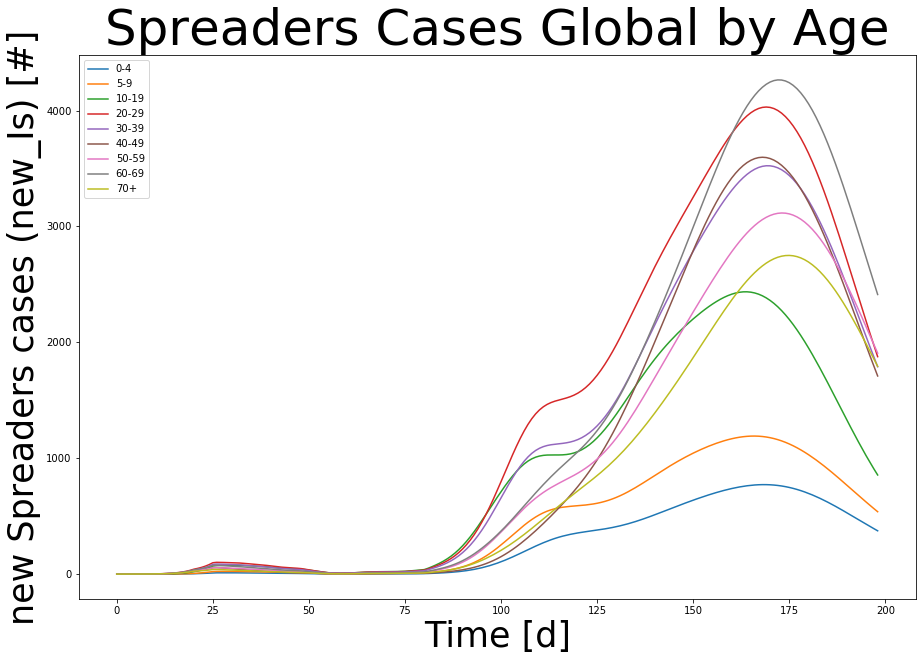

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xaa65390>)

In [15]:
mdl.plot_I_by_age(ind,results[((1, '-'), 0)], new_only=True)

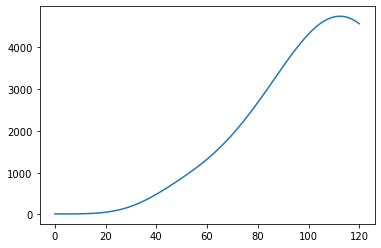

In [16]:
plt.plot(results[((1, '-'), 0)]['Vents'].sum(axis=1)[(start_inter-beginning).days:]*mdl.pop_israel)